![Deep Learning for Scientists in a hurry](./fig/Title.png)

In [1]:
%load_ext watermark

In [2]:
%watermark

Last updated: 2022-08-19T20:49:43.868976-04:00

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 8.4.0

Compiler    : GCC 9.4.0
OS          : Linux
Release     : 3.10.0-1160.24.1.el7.x86_64
Machine     : x86_64
Processor   : x86_64
CPU cores   : 52
Architecture: 64bit



In [3]:
import os
import time
start = time.time()
chapter_number = 4
import matplotlib
%matplotlib inline
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt

In [4]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import sklearn
import pydot
import tensorflow as tf
from tensorflow import keras

2022-08-19 20:49:45.006068: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [5]:
%watermark -iv

pandas    : 1.3.5
tensorflow: 2.9.1+nv22.07
numpy     : 1.21.1
sklearn   : 0.0
pydot     : 1.4.2
keras     : 2.9.0
matplotlib: 3.5.0



# Advanced topics on TensorFlow

## Keras Network Initializers

In [6]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'HeNormal',
 'HeUniform',
 'Identity',
 'Initializer',
 'LecunNormal',
 'LecunUniform',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'random_normal',
 'random_uniform',
 'serialize',
 'truncated_normal',
 'variance_scaling',
 'zeros']

In [7]:
keras.layers.Dense(10, activation="relu", kernel_initializer="he_normal")

In [8]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg',
                                          distribution='uniform')
keras.layers.Dense(10, activation="relu", kernel_initializer=init)

## Alternative Activation Functions

### Leaky ReLU

In [9]:
z = np.linspace(-5, 5, 200)

In [10]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

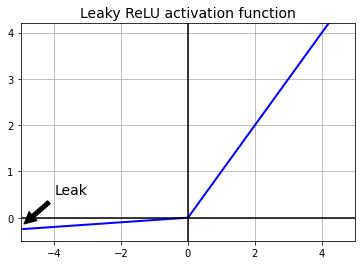

In [11]:
plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2]);

In [12]:
[m for m in dir(keras.activations) if not m.startswith("_")]

['deserialize',
 'elu',
 'exponential',
 'gelu',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'swish',
 'tanh']

In [13]:
[m for m in dir(keras.layers) if "relu" in m.lower()]

['LeakyReLU', 'PReLU', 'ReLU', 'ThresholdedReLU']

Let's train a neural network on Fashion MNIST using the Leaky ReLU:

In [14]:
import gzip

def load_data():
    dirname = './data/keras/datasets/fashion-mnist'
    files = [
        "train-labels-idx1-ubyte.gz",
        "train-images-idx3-ubyte.gz",
        "t10k-labels-idx1-ubyte.gz",
        "t10k-images-idx3-ubyte.gz",
    ]

    paths = []
    for fname in files:
        paths.append(dirname + os.sep + fname)

    with gzip.open(paths[0], "rb") as lbpath:
        y_train = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[1], "rb") as imgpath:
        x_train = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(
            len(y_train), 28, 28
        )

    with gzip.open(paths[2], "rb") as lbpath:
        y_test = np.frombuffer(lbpath.read(), np.uint8, offset=8)

    with gzip.open(paths[3], "rb") as imgpath:
        x_test = np.frombuffer(imgpath.read(), np.uint8, offset=16).reshape(
            len(y_test), 28, 28
        )

    return (x_train, y_train), (x_test, y_test)

In [15]:
#(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = load_data()
X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [16]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.LeakyReLU(),
    keras.layers.Dense(10, activation="softmax")
])

2022-08-19 20:49:47.501840: I tensorflow/core/platform/cpu_feature_guard.cc:194] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-19 20:49:48.777722: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21326 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:89:00.0, compute capability: 7.5
2022-08-19 20:49:48.778555: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 21326 MB memory:  -> device: 1, name: Quadro RTX 6000, pci bus id: 0000:8a:00.0, compute capability: 7.5
2022-08-19 20:49:48.779580: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/de

In [17]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [18]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 1.2819 - accuracy: 0.6229 - val_loss: 0.8886 - val_accuracy: 0.7160
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.7955 - accuracy: 0.7362 - val_loss: 0.7130 - val_accuracy: 0.7656
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6816 - accuracy: 0.7721 - val_loss: 0.6427 - val_accuracy: 0.7898
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6217 - accuracy: 0.7944 - val_loss: 0.5900 - val_accuracy: 0.8066
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5832 - accuracy: 0.8075 - val_loss: 0.5582 - val_accuracy: 0.8202
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5553 - accuracy: 0.8156 - val_loss: 0.5350 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5338 - accuracy: 0.8224 - val_loss: 0.5157 - val_accuracy:

Now let's try PReLU:

In [19]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(100, kernel_initializer="he_normal"),
    keras.layers.PReLU(),
    keras.layers.Dense(10, activation="softmax")
])

In [20]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [21]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 2ms/step - loss: 1.3461 - accuracy: 0.6209 - val_loss: 0.9255 - val_accuracy: 0.7186
Epoch 2/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8197 - accuracy: 0.7356 - val_loss: 0.7305 - val_accuracy: 0.7630
Epoch 3/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6966 - accuracy: 0.7693 - val_loss: 0.6565 - val_accuracy: 0.7878
Epoch 4/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.6331 - accuracy: 0.7909 - val_loss: 0.6003 - val_accuracy: 0.8048
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5917 - accuracy: 0.8056 - val_loss: 0.5656 - val_accuracy: 0.8178
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5618 - accuracy: 0.8135 - val_loss: 0.5406 - val_accuracy: 0.8238
Epoch 7/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5390 - accuracy: 0.8205 - val_loss: 0.5196 - val_accuracy:

### ELU

In [22]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha * (np.exp(z) - 1), z)

(-5.0, 5.0, -2.2, 3.2)

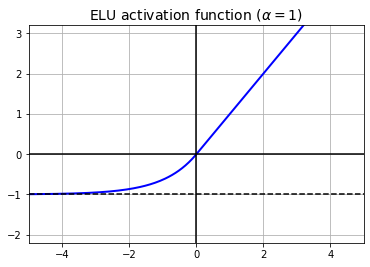

In [23]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

Implementing ELU in TensorFlow is trivial, just specify the activation function when building each layer:

In [24]:
keras.layers.Dense(10, activation="elu")

### SELU

This activation function was proposed in this [great paper](https://arxiv.org/pdf/1706.02515.pdf) by Günter Klambauer, Thomas Unterthiner, and Andreas Mayr, published in June 2017. During training, a neural network composed exclusively of a stack of dense layers using the SELU activation function and LeCun initialization will self-normalize: the output of each layer will tend to preserve the same mean and variance during training, which solves the vanishing/exploding gradients problem. As a result, this activation function outperforms the other activation functions very significantly for such neural nets, so you should try it out. Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use ℓ<sub>1</sub> or ℓ<sub>2</sub> regularization, regular dropout, max-norm, skip connections, or other non-sequential topologies (so recurrent neural networks won't self-normalize). However, in practice, it works quite well with sequential CNNs. If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [25]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [26]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

(-5.0, 5.0, -2.2, 3.2)

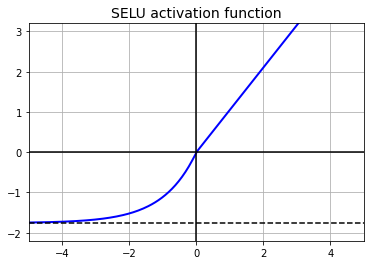

In [27]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

By default, the SELU hyperparameters (`scale` and `alpha`) are tuned in such a way that the mean output of each neuron remains close to 0, and the standard deviation remains close to 1 (assuming the inputs are standardized with mean 0 and standard deviation 1 too). Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem:

In [28]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1 / 100)) # LeCun initialization
    Z = selu(np.dot(Z, W))
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, std deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, std deviation 1.00
Layer 100: mean 0.02, std deviation 0.96
Layer 200: mean 0.01, std deviation 0.90
Layer 300: mean -0.02, std deviation 0.92
Layer 400: mean 0.05, std deviation 0.89
Layer 500: mean 0.01, std deviation 0.93
Layer 600: mean 0.02, std deviation 0.92
Layer 700: mean -0.02, std deviation 0.90
Layer 800: mean 0.05, std deviation 0.83
Layer 900: mean 0.02, std deviation 1.00


Using SELU is easy:

In [29]:
keras.layers.Dense(10, activation="selu",
                   kernel_initializer="lecun_normal")

Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function:

In [30]:
np.random.seed(42)
tf.random.set_seed(42)

In [31]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="selu",
                             kernel_initializer="lecun_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="selu",
                                 kernel_initializer="lecun_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [32]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

Now let's train it. Do not forget to scale the inputs to mean 0 and standard deviation 1:

In [33]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_stds = X_train.std(axis=0, keepdims=True)
X_train_scaled = (X_train - pixel_means) / pixel_stds
X_valid_scaled = (X_valid - pixel_means) / pixel_stds
X_test_scaled = (X_test - pixel_means) / pixel_stds

In [34]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 7ms/step - loss: 1.1183 - accuracy: 0.5763 - val_loss: 0.9346 - val_accuracy: 0.6656
Epoch 2/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.8220 - accuracy: 0.7037 - val_loss: 0.6761 - val_accuracy: 0.7628
Epoch 3/5
1719/1719 [==============================] - 13s 8ms/step - loss: 0.6571 - accuracy: 0.7661 - val_loss: 0.7972 - val_accuracy: 0.7032
Epoch 4/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5742 - accuracy: 0.7973 - val_loss: 0.5100 - val_accuracy: 0.8272
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.5180 - accuracy: 0.8210 - val_loss: 0.4766 - val_accuracy: 0.8364


Now look at what happens if we try to use the ReLU activation function instead:

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

In [36]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu", kernel_initializer="he_normal"))
for layer in range(99):
    model.add(keras.layers.Dense(100, activation="relu", kernel_initializer="he_normal"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [37]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [38]:
history = model.fit(X_train_scaled, y_train, epochs=5,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/5
1719/1719 [==============================] - 15s 8ms/step - loss: 1.8043 - accuracy: 0.2575 - val_loss: 1.3714 - val_accuracy: 0.3680
Epoch 2/5
1719/1719 [==============================] - 13s 7ms/step - loss: 1.2247 - accuracy: 0.4742 - val_loss: 1.0467 - val_accuracy: 0.5576
Epoch 3/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.9965 - accuracy: 0.5892 - val_loss: 0.8818 - val_accuracy: 0.6476
Epoch 4/5
1719/1719 [==============================] - 13s 7ms/step - loss: 0.7857 - accuracy: 0.6960 - val_loss: 0.7229 - val_accuracy: 0.7378
Epoch 5/5
1719/1719 [==============================] - 12s 7ms/step - loss: 0.7252 - accuracy: 0.7279 - val_loss: 0.6842 - val_accuracy: 0.7446


Not great at all, we suffered from the vanishing/exploding gradients problem.

# Batch Normalization

In [39]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [40]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization (BatchN  (None, 784)              3136      
 ormalization)                                                   
                                                                 
 dense_212 (Dense)           (None, 300)               235500    
                                                                 
 batch_normalization_1 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 dense_213 (Dense)           (None, 100)               30100     
                                                                 
 batch_normalization_2 (Batc  (None, 100)             

In [41]:
bn1 = model

In [42]:
#bn1.weights[:10]

In [43]:
bn1 = model.layers[1]
[(var.name, var.trainable) for var in bn1.weights]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

In [44]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [45]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8750 - accuracy: 0.7124 - val_loss: 0.5525 - val_accuracy: 0.8228
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5753 - accuracy: 0.8031 - val_loss: 0.4725 - val_accuracy: 0.8472
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5189 - accuracy: 0.8207 - val_loss: 0.4374 - val_accuracy: 0.8552
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4827 - accuracy: 0.8324 - val_loss: 0.4152 - val_accuracy: 0.8600
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4565 - accuracy: 0.8411 - val_loss: 0.3997 - val_accuracy: 0.8642
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4397 - accuracy: 0.8472 - val_loss: 0.3866 - val_accuracy: 0.8690
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4241 - accuracy: 0.8513 - val_loss: 0.3762 - val_accuracy:

Sometimes applying BN before the activation function works better (there's a debate on this topic). Moreover, the layer before a `BatchNormalization` layer does not need to have bias terms, since the `BatchNormalization` layer some as well, it would be a waste of parameters, so you can set `use_bias=False` when creating those layers:

In [46]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(300, use_bias=False),
    keras.layers.BatchNormalization(),
    keras.layers.Activation("relu"),
    keras.layers.Dense(100, use_bias=False),
    keras.layers.Activation("relu"),
    keras.layers.BatchNormalization(),
    keras.layers.Dense(10, activation="softmax")
])

In [47]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [48]:
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8626 - accuracy: 0.7094 - val_loss: 0.5651 - val_accuracy: 0.8098
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5799 - accuracy: 0.7994 - val_loss: 0.4796 - val_accuracy: 0.8384
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5195 - accuracy: 0.8192 - val_loss: 0.4444 - val_accuracy: 0.8490
Epoch 4/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4816 - accuracy: 0.8329 - val_loss: 0.4211 - val_accuracy: 0.8554
Epoch 5/10
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4568 - accuracy: 0.8396 - val_loss: 0.4066 - val_accuracy: 0.8618
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4412 - accuracy: 0.8454 - val_loss: 0.3956 - val_accuracy: 0.8626
Epoch 7/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4245 - accuracy: 0.8512 - val_loss: 0.3847 - val_accuracy:

## Gradient Clipping

All Keras optimizers accept `clipnorm` or `clipvalue` arguments:

In [49]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [50]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

## Reusing Pretrained Layers

### Reusing a Keras model

Let's split the fashion MNIST training set in two:
* `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
* `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.

The validation set and the test set are also split this way, but without restricting the number of images.

We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). However, since we are using `Dense` layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [51]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [52]:
X_train_A.shape

(43986, 28, 28)

In [53]:
X_train_B.shape

(200, 28, 28)

In [54]:
y_train_A[:30]

array([4, 0, 5, 7, 7, 7, 4, 4, 3, 4, 0, 1, 6, 3, 4, 3, 2, 6, 5, 3, 4, 5,
       1, 3, 4, 2, 0, 6, 7, 1], dtype=uint8)

In [55]:
y_train_B[:30]

array([1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
       0., 0., 1., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1.], dtype=float32)

In [56]:
tf.random.set_seed(42)
np.random.seed(42)

In [57]:
model_A = keras.models.Sequential()
model_A.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation="selu"))
model_A.add(keras.layers.Dense(8, activation="softmax"))

In [58]:
model_A.compile(loss="sparse_categorical_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [59]:
history = model_A.fit(X_train_A, y_train_A, epochs=10,
                    validation_data=(X_valid_A, y_valid_A))

Epoch 1/10
1375/1375 [==============================] - 3s 2ms/step - loss: 0.5926 - accuracy: 0.8103 - val_loss: 0.3895 - val_accuracy: 0.8665
Epoch 2/10
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3523 - accuracy: 0.8787 - val_loss: 0.3288 - val_accuracy: 0.8824
Epoch 3/10
1375/1375 [==============================] - 2s 2ms/step - loss: 0.3170 - accuracy: 0.8895 - val_loss: 0.3015 - val_accuracy: 0.8986
Epoch 4/10
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2973 - accuracy: 0.8975 - val_loss: 0.2893 - val_accuracy: 0.9018
Epoch 5/10
1375/1375 [==============================] - 2s 1ms/step - loss: 0.2834 - accuracy: 0.9021 - val_loss: 0.2775 - val_accuracy: 0.9053
Epoch 6/10
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2729 - accuracy: 0.9062 - val_loss: 0.2734 - val_accuracy: 0.9073
Epoch 7/10
1375/1375 [==============================] - 2s 2ms/step - loss: 0.2640 - accuracy: 0.9092 - val_loss: 0.2718 - val_accuracy:

In [60]:
model_A.save("my_model_A.h5")

In [61]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [62]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                metrics=["accuracy"])

In [63]:
history = model_B.fit(X_train_B, y_train_B, epochs=20,
                      validation_data=(X_valid_B, y_valid_B))

Epoch 1/20
7/7 [==============================] - 0s 27ms/step - loss: 0.9573 - accuracy: 0.4650 - val_loss: 0.6314 - val_accuracy: 0.6004
Epoch 2/20
7/7 [==============================] - 0s 10ms/step - loss: 0.5692 - accuracy: 0.7450 - val_loss: 0.4784 - val_accuracy: 0.8529
Epoch 3/20
7/7 [==============================] - 0s 10ms/step - loss: 0.4503 - accuracy: 0.8650 - val_loss: 0.4102 - val_accuracy: 0.8945
Epoch 4/20
7/7 [==============================] - 0s 10ms/step - loss: 0.3879 - accuracy: 0.8950 - val_loss: 0.3647 - val_accuracy: 0.9178
Epoch 5/20
7/7 [==============================] - 0s 10ms/step - loss: 0.3435 - accuracy: 0.9250 - val_loss: 0.3300 - val_accuracy: 0.9320
Epoch 6/20
7/7 [==============================] - 0s 10ms/step - loss: 0.3081 - accuracy: 0.9300 - val_loss: 0.3019 - val_accuracy: 0.9402
Epoch 7/20
7/7 [==============================] - 0s 10ms/step - loss: 0.2800 - accuracy: 0.9350 - val_loss: 0.2804 - val_accuracy: 0.9422
Epoch 8/20
7/7 [===========

In [64]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 784)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 784)              3136      
 hNormalization)                                                 
                                                                 
 dense_215 (Dense)           (None, 300)               235200    
                                                                 
 batch_normalization_4 (Batc  (None, 300)              1200      
 hNormalization)                                                 
                                                                 
 activation (Activation)     (None, 300)               0         
                                                                 
 dense_216 (Dense)           (None, 100)              

In [65]:
model_A = keras.models.load_model("my_model_A.h5")
model_B_on_A = keras.models.Sequential(model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation="sigmoid"))

In [66]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

In [67]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable = False

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])

In [68]:
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=4,
                           validation_data=(X_valid_B, y_valid_B))

for layer in model_B_on_A.layers[:-1]:
    layer.trainable = True

model_B_on_A.compile(loss="binary_crossentropy",
                     optimizer=keras.optimizers.SGD(learning_rate=1e-3),
                     metrics=["accuracy"])
history = model_B_on_A.fit(X_train_B, y_train_B, epochs=16,
                           validation_data=(X_valid_B, y_valid_B))

Epoch 1/4
7/7 [==============================] - 0s 27ms/step - loss: 0.5163 - accuracy: 0.7000 - val_loss: 0.5360 - val_accuracy: 0.6795
Epoch 2/4
7/7 [==============================] - 0s 10ms/step - loss: 0.4893 - accuracy: 0.7300 - val_loss: 0.5075 - val_accuracy: 0.7039
Epoch 3/4
7/7 [==============================] - 0s 10ms/step - loss: 0.4615 - accuracy: 0.7750 - val_loss: 0.4830 - val_accuracy: 0.7302
Epoch 4/4
7/7 [==============================] - 0s 10ms/step - loss: 0.4376 - accuracy: 0.7900 - val_loss: 0.4609 - val_accuracy: 0.7546
Epoch 1/16
7/7 [==============================] - 0s 27ms/step - loss: 0.3715 - accuracy: 0.8550 - val_loss: 0.3383 - val_accuracy: 0.8712
Epoch 2/16
7/7 [==============================] - 0s 10ms/step - loss: 0.2703 - accuracy: 0.9350 - val_loss: 0.2597 - val_accuracy: 0.9300
Epoch 3/16
7/7 [==============================] - 0s 10ms/step - loss: 0.2051 - accuracy: 0.9650 - val_loss: 0.2137 - val_accuracy: 0.9523
Epoch 4/16
7/7 [===============

So, what's the final verdict?

In [69]:
model_B.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.1408 - accuracy: 0.9705


[0.1408407837152481, 0.9704999923706055]

In [70]:
model_B_on_A.evaluate(X_test_B, y_test_B)

63/63 [==============================] - 0s 1ms/step - loss: 0.0716 - accuracy: 0.9930


[0.07164266705513, 0.9929999709129333]

Great! We got quite a bit of transfer: the error rate dropped by a factor of almost 4!

In [71]:
(100 - 97.05) / (100 - 99.25)

3.933333333333337

# Faster Optimizers

## Momentum optimization

In [72]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9)

## Nesterov Accelerated Gradient

In [73]:
optimizer = keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, nesterov=True)

## AdaGrad

In [74]:
optimizer = keras.optimizers.Adagrad(learning_rate=0.001)

## RMSProp

In [75]:
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)

## Adam Optimization

In [76]:
optimizer = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Adamax Optimization

In [77]:
optimizer = keras.optimizers.Adamax(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Nadam Optimization

In [78]:
optimizer = keras.optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)

## Learning Rate Scheduling

### Power Scheduling

```lr = lr0 / (1 + steps / s)**c```
* Keras uses `c=1` and `s = 1 / decay`

In [79]:
optimizer = keras.optimizers.SGD(learning_rate=0.01, decay=1e-4)

In [80]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [81]:
n_epochs = 10
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/10
1719/1719 [==============================] - 3s 1ms/step - loss: 0.4855 - accuracy: 0.8304 - val_loss: 0.4029 - val_accuracy: 0.8600
Epoch 2/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3781 - accuracy: 0.8657 - val_loss: 0.3715 - val_accuracy: 0.8730
Epoch 3/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3459 - accuracy: 0.8772 - val_loss: 0.3748 - val_accuracy: 0.8750
Epoch 4/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3251 - accuracy: 0.8829 - val_loss: 0.3503 - val_accuracy: 0.8800
Epoch 5/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.3103 - accuracy: 0.8888 - val_loss: 0.3449 - val_accuracy: 0.8790
Epoch 6/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2967 - accuracy: 0.8932 - val_loss: 0.3413 - val_accuracy: 0.8828
Epoch 7/10
1719/1719 [==============================] - 2s 1ms/step - loss: 0.2869 - accuracy: 0.8971 - val_loss: 0.3357 - val_accuracy:

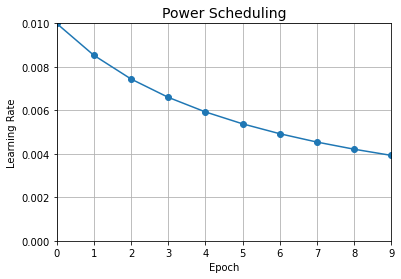

In [82]:
learning_rate = 0.01
decay = 1e-4
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
epochs = np.arange(n_epochs)
lrs = learning_rate / (1 + decay * epochs * n_steps_per_epoch)

plt.plot(epochs, lrs,  "o-")
plt.axis([0, n_epochs - 1, 0, 0.01])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Power Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Exponential Scheduling

```lr = lr0 * 0.1**(epoch / s)```

In [83]:
def exponential_decay_fn(epoch):
    return 0.01 * 0.1**(epoch / 20)

In [84]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1**(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [85]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25

In [86]:
lr_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8490 - accuracy: 0.7535 - val_loss: 0.8343 - val_accuracy: 0.7514 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.7191 - accuracy: 0.7871 - val_loss: 0.6497 - val_accuracy: 0.8038 - lr: 0.0089
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5774 - accuracy: 0.8217 - val_loss: 0.6959 - val_accuracy: 0.8008 - lr: 0.0079
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5266 - accuracy: 0.8345 - val_loss: 0.4506 - val_accuracy: 0.8560 - lr: 0.0071
Epoch 5/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4739 - accuracy: 0.8489 - val_loss: 0.4698 - val_accuracy: 0.8646 - lr: 0.0063
Epoch 6/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4509 - accuracy: 0.8587 - val_loss: 0.4708 - val_accuracy: 0.8554 - lr: 0.0056
Epoch 7/25
1719/1719 [==============================] - 3s

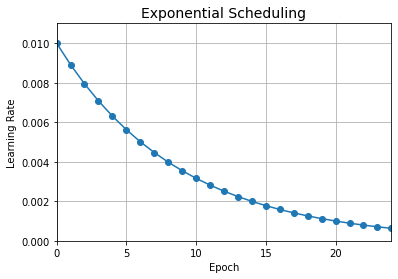

In [87]:
plt.plot(history.epoch, history.history["lr"], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling", fontsize=14)
plt.grid(True)
plt.show()

The schedule function can take the current learning rate as a second argument:

In [88]:
def exponential_decay_fn(epoch, lr):
    return lr * 0.1**(1 / 20)

If you want to update the learning rate at each iteration rather than at each epoch, you must write your own callback class:

In [89]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s

    def on_batch_begin(self, batch, logs=None):
        # Note: the `batch` argument is reset at each epoch
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr * 0.1**(1 / s))

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
lr0 = 0.01
optimizer = keras.optimizers.Nadam(learning_rate=lr0)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 10

s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
exp_decay = ExponentialDecay(s)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[exp_decay])

Epoch 1/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8096 - accuracy: 0.7627 - val_loss: 0.8749 - val_accuracy: 0.7318 - lr: 0.0089
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.6155 - accuracy: 0.8081 - val_loss: 0.6640 - val_accuracy: 0.8188 - lr: 0.0079
Epoch 3/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5926 - accuracy: 0.8214 - val_loss: 0.6236 - val_accuracy: 0.7984 - lr: 0.0071
Epoch 4/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5359 - accuracy: 0.8376 - val_loss: 0.5839 - val_accuracy: 0.8524 - lr: 0.0063
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4642 - accuracy: 0.8523 - val_loss: 0.4630 - val_accuracy: 0.8642 - lr: 0.0056
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4339 - accuracy: 0.8609 - val_loss: 0.4796 - val_accuracy: 0.8614 - lr: 0.0050
Epoch 7/10
1719/1719 [==============================] - 4s

In [90]:
n_steps = n_epochs * len(X_train) // 32
steps = np.arange(n_steps)
lrs = lr0 * 0.1**(steps / s)

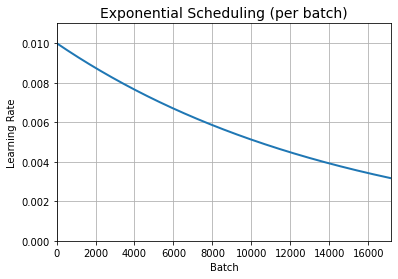

In [91]:
plt.plot(steps, lrs, "-", linewidth=2)
plt.axis([0, n_steps - 1, 0, lr0 * 1.1])
plt.xlabel("Batch")
plt.ylabel("Learning Rate")
plt.title("Exponential Scheduling (per batch)", fontsize=14)
plt.grid(True)
plt.show()

### Piecewise Constant Scheduling

In [92]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [93]:
def piecewise_constant(boundaries, values):
    boundaries = np.array([0] + boundaries)
    values = np.array(values)
    def piecewise_constant_fn(epoch):
        return values[np.argmax(boundaries > epoch) - 1]
    return piecewise_constant_fn

piecewise_constant_fn = piecewise_constant([5, 15], [0.01, 0.005, 0.001])

In [94]:
lr_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 4s 2ms/step - loss: 0.8678 - accuracy: 0.7529 - val_loss: 0.8264 - val_accuracy: 0.7376 - lr: 0.0100
Epoch 2/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8092 - accuracy: 0.7615 - val_loss: 0.7097 - val_accuracy: 0.7850 - lr: 0.0100
Epoch 3/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.8554 - accuracy: 0.7573 - val_loss: 1.6901 - val_accuracy: 0.6790 - lr: 0.0100
Epoch 4/25
1719/1719 [==============================] - 3s 2ms/step - loss: 0.9384 - accuracy: 0.7083 - val_loss: 1.3126 - val_accuracy: 0.5662 - lr: 0.0100
Epoch 5/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.2424 - accuracy: 0.5368 - val_loss: 1.3052 - val_accuracy: 0.5352 - lr: 0.0100
Epoch 6/25
1719/1719 [==============================] - 3s 2ms/step - loss: 1.0369 - accuracy: 0.5665 - val_loss: 1.0858 - val_accuracy: 0.5922 - lr: 0.0050
Epoch 7/25
1719/1719 [==============================] - 3s

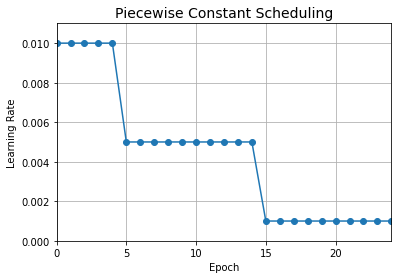

In [95]:
plt.plot(history.epoch, [piecewise_constant_fn(epoch) for epoch in history.epoch], "o-")
plt.axis([0, n_epochs - 1, 0, 0.011])
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Piecewise Constant Scheduling", fontsize=14)
plt.grid(True)
plt.show()

### Performance Scheduling

In [96]:
tf.random.set_seed(42)
np.random.seed(42)

In [97]:
lr_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.02, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[lr_scheduler])

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.5908 - accuracy: 0.8063 - val_loss: 0.5186 - val_accuracy: 0.8474 - lr: 0.0200
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5000 - accuracy: 0.8396 - val_loss: 0.6500 - val_accuracy: 0.8244 - lr: 0.0200
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5090 - accuracy: 0.8426 - val_loss: 0.5114 - val_accuracy: 0.8526 - lr: 0.0200
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5205 - accuracy: 0.8447 - val_loss: 0.5023 - val_accuracy: 0.8560 - lr: 0.0200
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5186 - accuracy: 0.8493 - val_loss: 0.4939 - val_accuracy: 0.8506 - lr: 0.0200
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.5039 - accuracy: 0.8527 - val_loss: 0.5256 - val_accuracy: 0.8562 - lr: 0.0200
Epoch 7/25
1719/1719 [==============================] - 2s

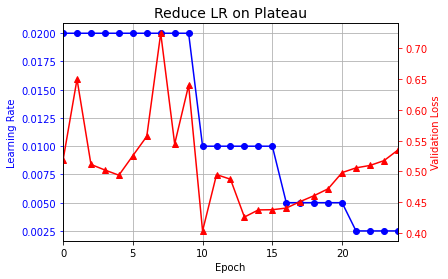

In [98]:
plt.plot(history.epoch, history.history["lr"], "bo-")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate", color='b')
plt.tick_params('y', colors='b')
plt.gca().set_xlim(0, n_epochs - 1)
plt.grid(True)

ax2 = plt.gca().twinx()
ax2.plot(history.epoch, history.history["val_loss"], "r^-")
ax2.set_ylabel('Validation Loss', color='r')
ax2.tick_params('y', colors='r')

plt.title("Reduce LR on Plateau", fontsize=14)
plt.show()

### tf.keras schedulers

In [99]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
s = 20 * len(X_train) // 32 # number of steps in 20 epochs (batch size = 32)
#learning_rate = keras.optimizers.schedules.ExponentialDecay(0.01, s, 0.1)
#optimizer = keras.optimizers.SGD(learning_rate)
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=1/s, decay=0.1, nesterov=False)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 25
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/25
1719/1719 [==============================] - 3s 1ms/step - loss: 0.7364 - accuracy: 0.7525 - val_loss: 0.6650 - val_accuracy: 0.7808
Epoch 2/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6754 - accuracy: 0.7728 - val_loss: 0.6464 - val_accuracy: 0.7872
Epoch 3/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6617 - accuracy: 0.7771 - val_loss: 0.6369 - val_accuracy: 0.7902
Epoch 4/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6537 - accuracy: 0.7795 - val_loss: 0.6307 - val_accuracy: 0.7914
Epoch 5/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6482 - accuracy: 0.7812 - val_loss: 0.6262 - val_accuracy: 0.7920
Epoch 6/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6440 - accuracy: 0.7822 - val_loss: 0.6226 - val_accuracy: 0.7930
Epoch 7/25
1719/1719 [==============================] - 2s 1ms/step - loss: 0.6406 - accuracy: 0.7833 - val_loss: 0.6197 - val_accuracy:

For piecewise constant scheduling, try this:

In [100]:
#learning_rate = keras.optimizers.schedules.PiecewiseConstantDecay(
#    boundaries=[5. * n_steps_per_epoch, 15. * n_steps_per_epoch],
#    values=[0.01, 0.005, 0.001])

### 1Cycle scheduling

In [101]:
K = keras.backend

class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.lr))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.lr, self.model.optimizer.lr * self.factor)

def find_learning_rate(model, X, y, epochs=1, batch_size=32, min_rate=10**-5, max_rate=10):
    init_weights = model.get_weights()
    iterations = len(X) // batch_size * epochs
    factor = np.exp(np.log(max_rate / min_rate) / iterations)
    init_lr = K.get_value(model.optimizer.lr)
    K.set_value(model.optimizer.lr, min_rate)
    exp_lr = ExponentialLearningRate(factor)
    history = model.fit(X, y, epochs=epochs, batch_size=batch_size, callbacks=[exp_lr])
    K.set_value(model.optimizer.lr, init_lr)
    model.set_weights(init_weights)
    return exp_lr.rates, exp_lr.losses

def plot_lr_vs_loss(rates, losses):
    plt.plot(rates, losses)
    plt.gca().set_xscale('log')
    plt.hlines(min(losses), min(rates), max(rates))
    plt.axis([min(rates), max(rates), min(losses), (losses[0] + min(losses)) / 2])
    plt.xlabel("Learning rate")
    plt.ylabel("Loss")

In [102]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])

In [103]:
X_train_scaled.shape

(55000, 28, 28)

In [104]:
y_train.shape

(55000,)

In [105]:
batch_size = 100
#rates, losses = find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
#find_learning_rate(model, X_train_scaled, y_train, epochs=1, batch_size=batch_size)
#plot_lr_vs_loss(rates, losses)

In [106]:
class OneCycleScheduler(keras.callbacks.Callback):
    def __init__(self, iterations, max_rate, start_rate=None,
                 last_iterations=None, last_rate=None):
        self.iterations = iterations
        self.max_rate = max_rate
        self.start_rate = start_rate or max_rate / 10
        self.last_iterations = last_iterations or iterations // 10 + 1
        self.half_iteration = (iterations - self.last_iterations) // 2
        self.last_rate = last_rate or self.start_rate / 1000
        self.iteration = 0
    def _interpolate(self, iter1, iter2, rate1, rate2):
        return ((rate2 - rate1) * (iter2 - self.iteration)
                / (iter2 - iter1) + rate1)
    def on_batch_begin(self, batch, logs):
        if self.iteration < self.half_iteration:
            rate = self._interpolate(0, self.half_iteration, self.start_rate, self.max_rate)
        elif self.iteration < 2 * self.half_iteration:
            rate = self._interpolate(self.half_iteration, 2 * self.half_iteration,
                                     self.max_rate, self.start_rate)
        else:
            rate = self._interpolate(2 * self.half_iteration, self.iterations,
                                     self.start_rate, self.last_rate)
            rate = max(rate, self.last_rate)
        self.iteration += 1
        K.set_value(self.model.optimizer.lr, rate)

In [107]:
n_epochs = 25
onecycle = OneCycleScheduler(len(X_train) // batch_size * n_epochs, max_rate=0.05)
history = model.fit(X_train_scaled, y_train, epochs=n_epochs, batch_size=batch_size,
                    validation_data=(X_valid_scaled, y_valid),
                    callbacks=[onecycle])

Epoch 1/25
550/550 [==============================] - 1s 2ms/step - loss: 0.4836 - accuracy: 0.8295 - val_loss: 0.3926 - val_accuracy: 0.8644
Epoch 2/25
550/550 [==============================] - 1s 2ms/step - loss: 0.3697 - accuracy: 0.8679 - val_loss: 0.3585 - val_accuracy: 0.8728
Epoch 3/25
550/550 [==============================] - 1s 2ms/step - loss: 0.3345 - accuracy: 0.8797 - val_loss: 0.3570 - val_accuracy: 0.8722
Epoch 4/25
550/550 [==============================] - 1s 2ms/step - loss: 0.3094 - accuracy: 0.8888 - val_loss: 0.3401 - val_accuracy: 0.8808
Epoch 5/25
550/550 [==============================] - 1s 2ms/step - loss: 0.2915 - accuracy: 0.8943 - val_loss: 0.3339 - val_accuracy: 0.8782
Epoch 6/25
550/550 [==============================] - 1s 2ms/step - loss: 0.2740 - accuracy: 0.9025 - val_loss: 0.3349 - val_accuracy: 0.8810
Epoch 7/25
550/550 [==============================] - 1s 2ms/step - loss: 0.2616 - accuracy: 0.9068 - val_loss: 0.3299 - val_accuracy: 0.8820
Epoch 

# Avoiding Overfitting Through Regularization

## $\ell_1$ and $\ell_2$ regularization

In [108]:
layer = keras.layers.Dense(100, activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))
# or l1(0.1) for ℓ1 regularization with a factor or 0.1
# or l1_l2(0.1, 0.01) for both ℓ1 and ℓ2 regularization, with factors 0.1 and 0.01 respectively

In [109]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(100, activation="elu",
                       kernel_initializer="he_normal",
                       kernel_regularizer=keras.regularizers.l2(0.01)),
    keras.layers.Dense(10, activation="softmax",
                       kernel_regularizer=keras.regularizers.l2(0.01))
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.5956 - accuracy: 0.8124 - val_loss: 0.7169 - val_accuracy: 0.8340
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7197 - accuracy: 0.8274 - val_loss: 0.6850 - val_accuracy: 0.8376


In [110]:
from functools import partial

RegularizedDense = partial(keras.layers.Dense,
                           activation="elu",
                           kernel_initializer="he_normal",
                           kernel_regularizer=keras.regularizers.l2(0.01))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    RegularizedDense(300),
    RegularizedDense(100),
    RegularizedDense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 1.6313 - accuracy: 0.8113 - val_loss: 0.7218 - val_accuracy: 0.8310
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.7187 - accuracy: 0.8273 - val_loss: 0.6826 - val_accuracy: 0.8382


## Dropout

In [111]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(300, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal"),
    keras.layers.Dropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.5838 - accuracy: 0.7997 - val_loss: 0.3730 - val_accuracy: 0.8644
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4209 - accuracy: 0.8442 - val_loss: 0.3410 - val_accuracy: 0.8728


## Alpha Dropout

In [112]:
tf.random.set_seed(42)
np.random.seed(42)

In [113]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(300, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal"),
    keras.layers.AlphaDropout(rate=0.2),
    keras.layers.Dense(10, activation="softmax")
])
optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
n_epochs = 20
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.6617 - accuracy: 0.7611 - val_loss: 0.5763 - val_accuracy: 0.8408
Epoch 2/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5547 - accuracy: 0.7965 - val_loss: 0.5437 - val_accuracy: 0.8480
Epoch 3/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5256 - accuracy: 0.8064 - val_loss: 0.5006 - val_accuracy: 0.8556
Epoch 4/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.5047 - accuracy: 0.8138 - val_loss: 0.4790 - val_accuracy: 0.8586
Epoch 5/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4922 - accuracy: 0.8174 - val_loss: 0.4612 - val_accuracy: 0.8614
Epoch 6/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4837 - accuracy: 0.8200 - val_loss: 0.4908 - val_accuracy: 0.8576
Epoch 7/20
1719/1719 [==============================] - 3s 2ms/step - loss: 0.4712 - accuracy: 0.8252 - val_loss: 0.5080 - val_accuracy:

In [114]:
model.evaluate(X_test_scaled, y_test)

313/313 [==============================] - 0s 1ms/step - loss: 0.4757 - accuracy: 0.8587


[0.47570884227752686, 0.8586999773979187]

In [115]:
model.evaluate(X_train_scaled, y_train)

1719/1719 [==============================] - 2s 1ms/step - loss: 0.3483 - accuracy: 0.8827


[0.34834492206573486, 0.8827272653579712]

In [116]:
history = model.fit(X_train_scaled, y_train)

1719/1719 [==============================] - 3s 2ms/step - loss: 0.4183 - accuracy: 0.8448


## MC Dropout

In [117]:
tf.random.set_seed(42)
np.random.seed(42)

In [118]:
#y_probas = np.stack([model(X_test_scaled, training=True)
#                     for sample in range(100)])
#y_proba = y_probas.mean(axis=0)
#y_std = y_probas.std(axis=0)

In [119]:
#np.round(model.predict(X_test_scaled[:1]), 2)

In [120]:
#np.round(y_probas[:, :1], 2)

In [121]:
#np.round(y_proba[:1], 2)

In [122]:
#y_std = y_probas.std(axis=0)
#np.round(y_std[:1], 2)

In [123]:
#y_pred = np.argmax(y_proba, axis=1)

In [124]:
#accuracy = np.sum(y_pred == y_test) / len(y_test)
#accuracy

In [125]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

class MCAlphaDropout(keras.layers.AlphaDropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

In [126]:
tf.random.set_seed(42)
np.random.seed(42)

In [127]:
#mc_model = keras.models.Sequential([
#    MCAlphaDropout(layer.rate) if isinstance(layer, keras.layers.AlphaDropout) else layer
#    for layer in model.layers
#])

In [128]:
#mc_model.summary()

In [129]:
#optimizer = keras.optimizers.SGD(learning_rate=0.01, momentum=0.9, nesterov=True)
#mc_model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

In [130]:
#mc_model.set_weights(model.get_weights())

Now we can use the model with MC Dropout:

In [131]:
#np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range(100)], axis=0), 2)

## Max norm

In [132]:
layer = keras.layers.Dense(100, activation="selu", kernel_initializer="lecun_normal",
                           kernel_constraint=keras.constraints.max_norm(1.))

In [133]:
MaxNormDense = partial(keras.layers.Dense,
                       activation="selu", kernel_initializer="lecun_normal",
                       kernel_constraint=keras.constraints.max_norm(1.))

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    MaxNormDense(300),
    MaxNormDense(100),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
n_epochs = 2
history = model.fit(X_train_scaled, y_train, epochs=n_epochs,
                    validation_data=(X_valid_scaled, y_valid))

Epoch 1/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.4747 - accuracy: 0.8329 - val_loss: 0.3712 - val_accuracy: 0.8640
Epoch 2/2
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3543 - accuracy: 0.8713 - val_loss: 0.3782 - val_accuracy: 0.8658


---

# References

There are many books about Deep Learning and many more on Machine Learning. 
This list is by no means an exhaustive list of books. I am listing the books from which I took inspiration. Also, I am listing materials where I found better ways to present topics. Often I am amazed by how people can create approachable materials for seemingly dry subjects.

The order of the books goes from divulgation and practical to the more rigorous and mathematical. Slides, blogs, and videos are those I have found over the internet or suggested by others.

### Selection of Books on Deep Learning

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Kelleher" 
       src="./fig/books/Deep Learning - Kelleher.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      John D. Kelleher<br>
      2019<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Charniak" 
       src="./fig/books/Introduction to Deep Learning - Charniak.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Eugene Charniak<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Introduction to Deep Learning - Skansi" 
       src="./fig/books/Introduction to Deep Learning - Skansi.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Introduction to Deep Learning<br>
      Sandro Skansi<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Subramanian" 
       src="./fig/books/Deep Learning with PyTorch - Subramanian.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Vishnu Subramanian<br>
      2018<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with PyTorch - Stevens" 
       src="./fig/books/Deep Learning with PyTorch - Stevens.png" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with PyTorch<br>
      Eli Stevens, Luca Artiga and Thomas Viehmann<br>
      2020<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning with Python - Chollet" 
       src="./fig/books/Deep Learning with Python - Chollet.jpg" 
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning with Python (Second Edition)<br>
      François Chollet<br>
      2021<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Patterson" 
       src="./fig/books/Deep Learning - Patterson.jpeg"
       height="100" width="100" />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning, a practitioner's approach<br>
      Josh Patterson and Adam Gibson<br>
      2017<br>
  </div>
</div>

<br>
<div style="clear: both; display: table;">
  <div style="border: none; float: left; width: 200; padding: 5px">
  <img alt="Deep Learning - Goodfellow" 
       src="./fig/books/Deep Learning - Goodfellow.jpg" 
       height="100" width="100"  />
  </div>
  <div style="border: none; float: left; width: 800; padding: 5px">
      Deep Learning<br>
      Ian Goodfellow, Yoshua Bengio, and Aaron Courville<br>
      2016<br>
  </div>
</div>

### Interactive Books

  * [Dive into Deep Learning](https://d2l.ai/index.html)<br>
    Interactive deep learning book with code, math, and discussions<br> 
    Implemented with PyTorch, NumPy/MXNet, and TensorFlow<br>
    Adopted at 300 universities from 55 countries


### Slides

  * John Urbanic's ["Deep Learning in one Afternoon"](https://www.psc.edu/wp-content/uploads/2022/04/Deep-Learning.pdf)<br>
An excellent fast, condensed introduction to Deep Learning.<br>
John is a Parallel Computing Scientist at Pittsburgh Supercomputing Center

  * [Christopher Olah's Blog](http://colah.github.io) is very good. For example about [Back Propagation](http://colah.github.io/posts/2015-08-Backprop)

  * Adam W. Harley on his CMU page offers [An Interactive Node-Link Visualization of Convolutional Neural Networks](https://www.cs.cmu.edu/~aharley/vis/)



### Jupyter Notebooks

 * [Yale Digital Humanities Lab](https://github.com/YaleDHLab/lab-workshops)
 
 * Aurelien Geron Hands-on Machine Learning with Scikit-learn 
   [First Edition](https://github.com/ageron/handson-ml) and
   [Second Edition](https://github.com/ageron/handson-ml2)
   
 * [A progressive collection notebooks of the Machine Learning course by the University of Turin](https://github.com/rugantio/MachineLearningCourse)
   
 * [A curated set of jupyter notebooks about many topics](https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks)
   
### Videos

 * [Caltech's "Learning from Data" by Professor Yaser Abu-Mostafa](https://work.caltech.edu/telecourse.html)
 
 * [3Blue1Brown Youtube Channel](https://www.youtube.com/watch?v=Ilg3gGewQ5U)
 
 ---

# Back of the Book

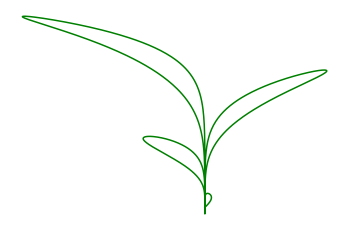

In [134]:
n = chapter_number
t = np.linspace(0, (2*(n-1)+1)*np.pi/2, 1000)
x = t*np.cos(t)**3
y = 9*t*np.sqrt(np.abs(np.cos(t))) + t*np.sin(0.3*t)*np.cos(2*t)
plt.plot(x, y, c="green")
plt.axis('off');

In [135]:
end = time.time()
print(f'Chapter {chapter_number} took {int(end - start):d} seconds')

Chapter 4 took 775 seconds
